In [ ]:
import numpy as np

path = "doc2vec_embds.txt"

with open(path, "r") as f:
    lines = [line.strip() for line in f if line.strip()]

embeddings = [list(map(float, line.split(","))) for line in lines]
embeddings = np.array(embeddings, dtype=np.float32)

print(f"Loaded embeddings shape: {embeddings.shape}")


Loaded embeddings: (18929, 762)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data_file = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df = pd.read_csv(data_file, encoding="latin-1")
print(f"Loaded {len(df)} samples.")
counts = df["author"].value_counts().sort_index()
plt.figure(figsize=(8, 5))
counts.plot(kind="bar")
plt.xlabel("Author")
plt.ylabel("Number of Samples")
plt.title("Samples per Author")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

emb_np   = np.loadtxt("doc2vec_embds.txt", delimiter=",")    # (N, 762)
train_path = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df       = pd.read_csv(train_path, encoding="latin-1")
authors  = sorted(df["author"].unique())
author2idx = {a:i for i,a in enumerate(authors)}
labels_np  = df["author"].map(author2idx).values                # (N,)
labels_t   = torch.tensor(labels_np, dtype=torch.long)

In [ ]:
import torch
import torch.nn as nn

state = torch.load("../Models/best_style_encoder.pt", map_location="cpu")

w_name = next(k for k in state if k.endswith("weight"))
b_name = next(k for k in state if k.endswith("bias"))

print(f"Found weights: {w_name} {state[w_name].shape}")

out_dim, in_dim = state[w_name].shape
print(f"Building Linear({in_dim} → {out_dim})")

model = nn.Linear(in_dim, out_dim)
model.load_state_dict({"weight": state[w_name], "bias": state[b_name]})
model.eval()

x = torch.randn(1, in_dim)
y = model(x)
print("Forward check:", x.shape, "→", y.shape)


In [ ]:
import torch
import torch.nn as nn

state = torch.load("../Models/best_style_encoder.pt", map_location="cuda:0")

w_name = next(k for k in state if k.endswith("weight"))
b_name = next(k for k in state if k.endswith("bias"))
out_dim, in_dim = state[w_name].shape

model = nn.Linear(in_dim, out_dim).cuda()
model.load_state_dict({
    "weight": state[w_name].cuda(),
    "bias": state[b_name].cuda()
})
model.eval()

x = torch.randn(1, in_dim, device="cuda:0")
y = model(x)

print("Model device:", next(model.parameters()).device)
print("Forward shape:", x.shape, "→", y.shape)


In [ ]:
import numpy as np
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

emb_np = np.loadtxt("doc2vec_embds.txt", delimiter=",")
emb_t = torch.from_numpy(emb_np).float().to(device)

print("Tensor ready:", emb_t.device, emb_t.shape)


In [ ]:
import pandas as pd
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

path = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df = pd.read_csv(path, encoding="latin-1")

authors = sorted(df.author.unique())
author2idx = {name: i for i, name in enumerate(authors)}

labels = torch.tensor(
    df.author.map(author2idx).values,
    dtype=torch.long,
    device=device
)

print("Labels device:", labels.device, "| shape:", labels.shape)


In [17]:
import torch

if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    total = props.total_memory / 1024**3
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    free = total - reserved
    print(f"Total VRAM:     {total:.2f} GB")
    print(f"Allocated:      {allocated:.2f} GB")
    print(f"Reserved:       {reserved:.2f} GB")
    print(f"Approx. Free:   {free:.2f} GB")
else:
    print("CUDA is not available.")

Total VRAM:     8.00 GB
Allocated:      0.06 GB
Reserved:       0.39 GB
Approx. Free:   7.60 GB


In [ ]:
import numpy as np
import pandas as pd
import torch

embeddings = np.loadtxt("doc2vec_embds.txt", delimiter=",")
n = embeddings.shape[0]

path = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df = pd.read_csv(path, encoding="latin-1").iloc[:n].reset_index(drop=True)

authors = sorted(df.author.unique())
author_to_num = {name: i + 1 for i, name in enumerate(authors)}

labels = df.author.map(author_to_num).values

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
labels_t = torch.from_numpy(labels).long().to(device)

print("Embeddings:", embeddings.shape)
print("Labels:", labels.shape, "| min/max:", labels.min(), "/", labels.max())
print("Labels tensor:", labels_t.device, labels_t.shape, "| unique:", torch.unique(labels_t))


Embeddings: (18929, 762)
Labels    : (18929,) min/max: 1 / 16
Tensor    : cuda:0 torch.Size([18929]) unique: tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       device='cuda:0')


In [16]:
import torch

# Suppose these are the only tensors you want to keep on GPU:
#   emb_t      – your padded Doc2Vec embeddings on CUDA
#   labels_t   – the 1–20 author labels on CUDA

# 1) delete everything else by name
for var in list(globals()):
    if var not in ("torch", "emb_t", "labels_t", "pd", "np", "GaussianMixture", "random"):
        try:
            obj = globals()[var]
            # if it’s a tensor on CUDA, delete it
            if isinstance(obj, torch.Tensor) and obj.device.type == "cuda":
                del globals()[var]
        except Exception:
            pass

# 2) empty the cache
torch.cuda.empty_cache()

# 3) sanity check
print(torch.cuda.memory_summary(device="cuda:0", abbreviated=True))


|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  67130 KiB |    923 MiB |   1105 MiB |   1040 MiB |
|---------------------------------------------------------------------------|
| Active memory         |  67130 KiB |    923 MiB |   1105 MiB |   1040 MiB |
|---------------------------------------------------------------------------|
| Requested memory      |  67129 KiB |    922 MiB |   1102 MiB |   1037 MiB |
|---------------------------------------------------------------

In [ ]:
import torch
import torch.nn.functional as F
import random

device = torch.device("cuda:0")

emb_raw = emb_t
emb_pad = F.pad(emb_raw, (0, 6))
with torch.no_grad():
    emb_proj = model(emb_pad)

sel_labels = torch.unique(labels_t)[:10]
k_model = 10
k_raw = 100

idxs_by_label = {
    int(l.item()): (labels_t == l).nonzero(as_tuple=True)[0].tolist()
    for l in sel_labels
}

support_idxs, query_idxs = [], []
for l in sel_labels.tolist():
    idxs = idxs_by_label[l]
    random.shuffle(idxs)
    support_idxs += idxs[:k_model]
    query_idxs += idxs[k_model:]

support_idxs = torch.tensor(support_idxs, device=device)
query_idxs = torch.tensor(query_idxs, device=device)

centers_proj = torch.stack([
    emb_proj[support_idxs[labels_t[support_idxs] == l]].median(dim=0).values
    for l in sel_labels.tolist()
], dim=0)

q_proj = emb_proj[query_idxs]
dists_proj = torch.cdist(q_proj, centers_proj)
pred_idx_proj = dists_proj.argmin(dim=1)
pred_labels_proj = sel_labels[pred_idx_proj]

few_acc = (pred_labels_proj == labels_t[query_idxs]).float().mean().item()
print(f"Few-shot (K={k_model}) model accuracy: {few_acc*100:.2f}%")

support_raw, query_raw = [], []
for l in sel_labels.tolist():
    idxs = idxs_by_label[l]
    random.shuffle(idxs)
    support_raw += idxs[:k_raw]
    query_raw += idxs[k_raw:]

support_raw = torch.tensor(support_raw, device=device)
query_raw = torch.tensor(query_raw, device=device)

centers_raw = torch.stack([
    emb_raw[support_raw[labels_t[support_raw] == l]].median(dim=0).values
    for l in sel_labels.tolist()
], dim=0)

q_raw = emb_raw[query_raw]
dists_raw = torch.cdist(q_raw, centers_raw)
pred_idx_raw = dists_raw.argmin(dim=1)
pred_labels_raw = sel_labels[pred_idx_raw]

raw_acc = (pred_labels_raw == labels_t[query_raw]).float().mean().item()
print(f"Doc2Vec baseline (K={k_raw}) accuracy: {raw_acc*100:.2f}%")


Few-shot (K=10) Model accuracy: 14.22%
Doc2Vec baseline (K=100) accuracy: 40.79%


C:\Users\sipay\miniconda3\envs\anime_rec_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.176s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.620093
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.610771
[t-SNE] KL divergence after 1000 iterations: 3.299585
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.002s...
[t-SNE] Computed neighbors for 3000 samples in 0.157s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 1.038752


C:\Users\sipay\miniconda3\envs\anime_rec_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 78.898926
[t-SNE] KL divergence after 1000 iterations: 3.070384


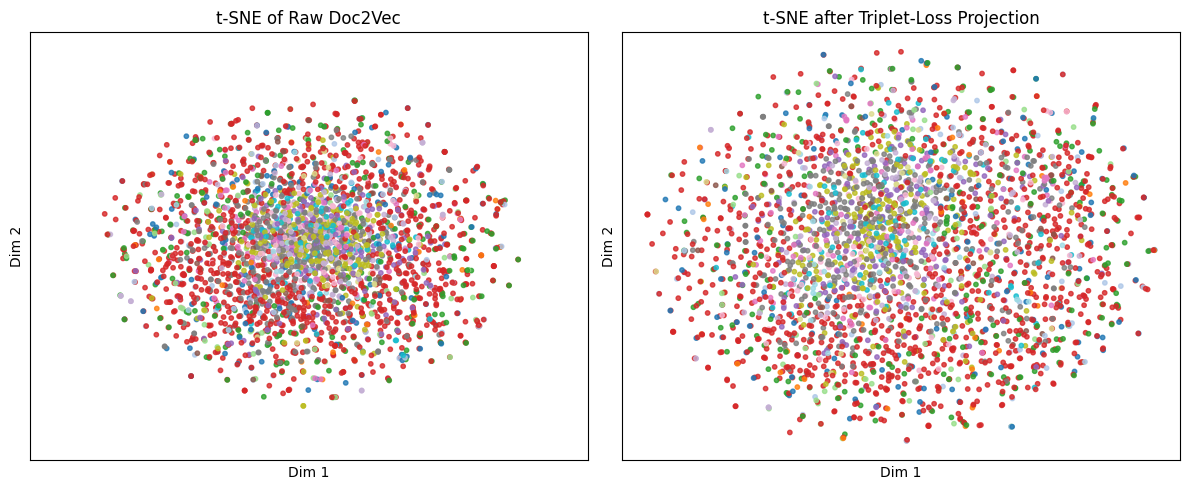

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

device = next(model.parameters()).device
emb_raw_t = torch.from_numpy(emb_np).float().to(device)

with torch.no_grad():
    emb_pad_t = F.pad(emb_raw_t, (0, 6))
    emb_proj_t = model(emb_pad_t)

emb_raw = emb_raw_t.cpu().numpy()
emb_proj = emb_proj_t.cpu().numpy()
labels = labels_np

max_pts = 3000
if emb_raw.shape[0] > max_pts:
    rng = np.random.RandomState(0)
    idxs = rng.permutation(len(emb_raw))[:max_pts]
    emb_raw = emb_raw[idxs]
    emb_proj = emb_proj[idxs]
    labels = labels[idxs]

tsne = TSNE(
    n_components=2,
    init="pca",
    random_state=42,
    perplexity=30,
    n_iter=1000,
    verbose=1
)

emb_raw_2d = tsne.fit_transform(emb_raw)
emb_proj_2d = tsne.fit_transform(emb_proj)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.scatter(emb_raw_2d[:, 0], emb_raw_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
ax1.set_title("t-SNE of Raw Doc2Vec")

ax2.scatter(emb_proj_2d[:, 0], emb_proj_2d[:, 1], c=labels, cmap="tab20", s=10, alpha=0.8)
ax2.set_title("t-SNE after Triplet-Loss Projection")

for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("Dim 1")
    ax.set_ylabel("Dim 2")

plt.tight_layout()
plt.show()


In [20]:
device = torch.device("cuda:0")
assert emb_t.device == device,  f"emb_t must be on {device}, not {emb_t.device}"
assert labels_t.device == device, f"labels_t must be on {device}, not {labels_t.device}"
print("✅ Data already on:", emb_t.device, labels_t.device)

✅ Data already on: cuda:0 cuda:0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from collections import defaultdict

device = torch.device("cuda:0")

assert emb_t.device == device, f"Expected emb_t on {device}"
assert labels_t.device == device, f"Expected labels_t on {device}"
print("✅ Data loaded on:", device)

class TripletDataset(Dataset):
    def __init__(self, indices):
        self.idxs = indices
        self.by_label = defaultdict(list)
        for i in self.idxs:
            l = int(labels_t[i].item())
            self.by_label[l].append(i)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, _):
        a = random.choice(self.idxs)
        la = int(labels_t[a].item())
        pos = a
        while pos == a:
            pos = random.choice(self.by_label[la])
        neg_label = random.choice([l for l in self.by_label if l != la])
        neg = random.choice(self.by_label[neg_label])
        return a, pos, neg

class EmbeddingNet(nn.Module):
    def __init__(self, dim=762, p_dropout=0.1):
        super().__init__()
        self.drop = nn.Dropout(p_dropout)
        self.fc = nn.Linear(dim, dim)
    def forward(self, x):
        return self.fc(self.drop(x))

def run_experiment(train_frac):
    idxs_by_label = {
        l: (labels_t == l).nonzero(as_tuple=True)[0].tolist()
        for l in torch.unique(labels_t).tolist()
    }
    train_idxs, test_idxs = [], []
    for l, idxs in idxs_by_label.items():
        random.shuffle(idxs)
        cut = int(len(idxs) * train_frac)
        train_idxs += idxs[:cut]
        test_idxs += idxs[cut:]

    loader = DataLoader(TripletDataset(train_idxs), batch_size=128, shuffle=True, drop_last=True)

    model = EmbeddingNet().to(device)
    loss_fn = nn.TripletMarginLoss(margin=1.0)
    opt = torch.optim.Adam(model.parameters(), lr=5e-5)

    model.train()
    for ep in range(1, 30):
        total_loss = 0
        for a, p, n in loader:
            anc = emb_t[a]
            pos = emb_t[p]
            neg = emb_t[n]
            opt.zero_grad()
            la, lp, ln = model(anc), model(pos), model(neg)
            loss = loss_fn(la, lp, ln)
            loss.backward()
            opt.step()
            total_loss += loss.item() * a.size(0)
        print(f"[{int(train_frac * 100)}% train] Epoch {ep} loss: {total_loss / len(train_idxs):.4f}")

    model.eval()
    with torch.no_grad():
        proj = model(emb_t).cpu().numpy()
    labels_np = labels_t.cpu().numpy()

    centers = {}
    for l, idxs in idxs_by_label.items():
        pts = proj[np.array(train_idxs)[np.array(labels_np)[train_idxs] == l]]
        centers[l] = np.median(pts, axis=0)

    def acc(idxs):
        X = proj[idxs]
        y = labels_np[idxs]
        preds = []
        for x in X:
            dists = [np.linalg.norm(x - centers[l]) for l in centers]
            preds.append(int(np.argmin(dists)))
        return accuracy_score(y, preds)

    return acc(train_idxs), acc(test_idxs)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

for frac in [0.10, 0.80]:
    tr_acc, te_acc = run_experiment(frac)
    print(f"\n=> {int(frac * 100)}% train / {100 - int(frac * 100)}% test split")
    print(f"Train accuracy: {tr_acc * 100:.2f}%")
    print(f"Test accuracy: {te_acc * 100:.2f}%")


✅ Data already on: cuda:0 cuda:0
[10% train] Epoch 1 avg loss: 2.7557
[10% train] Epoch 2 avg loss: 2.5764
[10% train] Epoch 3 avg loss: 2.8221
[10% train] Epoch 4 avg loss: 2.6924
[10% train] Epoch 5 avg loss: 2.5979
[10% train] Epoch 6 avg loss: 2.5839
[10% train] Epoch 7 avg loss: 2.3795
[10% train] Epoch 8 avg loss: 2.4058
[10% train] Epoch 9 avg loss: 2.4280
[10% train] Epoch 10 avg loss: 2.4467
[10% train] Epoch 11 avg loss: 2.3049
[10% train] Epoch 12 avg loss: 2.2959
[10% train] Epoch 13 avg loss: 2.1703
[10% train] Epoch 14 avg loss: 2.0394
[10% train] Epoch 15 avg loss: 1.9635
[10% train] Epoch 16 avg loss: 1.9089
[10% train] Epoch 17 avg loss: 1.9676
[10% train] Epoch 18 avg loss: 1.8083
[10% train] Epoch 19 avg loss: 1.7897
[10% train] Epoch 20 avg loss: 1.7185
[10% train] Epoch 21 avg loss: 1.5603
[10% train] Epoch 22 avg loss: 1.5084
[10% train] Epoch 23 avg loss: 1.4826
[10% train] Epoch 24 avg loss: 1.3770
[10% train] Epoch 25 avg loss: 1.3350
[10% train] Epoch 26 avg l

In [ ]:
import json
import torch

path = "../Data/masterembeddings.json"
with open(path, "r") as f:
    records = json.load(f)

max_row = max(rec["row"] for rec in records)
dim = len(records[0]["embedding"])

authors = sorted({rec["author"] for rec in records})
author_to_idx = {name: i for i, name in enumerate(authors)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
embeddings = torch.zeros((max_row + 1, dim), dtype=torch.float32, device=device)
labels = torch.zeros((max_row + 1,), dtype=torch.long, device=device)

for rec in records:
    r = rec["row"]
    embeddings[r] = torch.tensor(rec["embedding"], dtype=torch.float32, device=device)
    labels[r] = author_to_idx[rec["author"]]

print("Embeddings:", embeddings.shape, "on", embeddings.device)
print("Labels:", labels.shape, "on", labels.device)
print("Authors:", len(authors), "→", author_to_idx)


Embeddings tensor: torch.Size([21510, 768]) on cuda:0
Labels tensor:     torch.Size([21510]) on cuda:0
Num authors: 18 → {'1': 0, '10': 1, '11': 2, '12': 3, '13': 4, '14': 5, '15': 6, '16': 7, '17': 8, '18': 9, '19': 10, '2': 11, '20': 12, '3': 13, '4': 14, '6': 15, '8': 16, '9': 17}


In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from collections import defaultdict

device = torch.device("cuda:0")

class TripletDataset(Dataset):
    def __init__(self, indices):
        self.idxs = indices
        self.by_label = defaultdict(list)
        for i in self.idxs:
            lbl = int(master_labels_t[i].item())
            self.by_label[lbl].append(i)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, _):
        a = random.choice(self.idxs)
        la = int(master_labels_t[a].item())
        p = a
        while p == a:
            p = random.choice(self.by_label[la])
        neg_lbl = random.choice([l for l in self.by_label if l != la])
        n = random.choice(self.by_label[neg_lbl])
        return a, p, n

D = master_emb_t.size(1)

class StyleEncoder(nn.Module):
    def __init__(self, dim=D, dropout=0.3):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        z = self.fc(self.drop(x))
        return F.normalize(z, p=2, dim=1)

def run_experiment(train_frac, save_model=False):
    idxs_by_lbl = {
        lbl: (master_labels_t == lbl).nonzero(as_tuple=True)[0].tolist()
        for lbl in torch.unique(master_labels_t).tolist()
    }
    train_idxs, test_idxs = [], []
    for lbl, idxs in idxs_by_lbl.items():
        random.shuffle(idxs)
        cut = int(len(idxs) * train_frac)
        train_idxs += idxs[:cut]
        test_idxs += idxs[cut:]

    loader = DataLoader(TripletDataset(train_idxs), batch_size=64, shuffle=True, drop_last=True)

    model = StyleEncoder().to(device)
    loss_fn = nn.TripletMarginLoss(margin=0.5, p=2)
    opt = torch.optim.Adam(model.parameters(), lr=5e-5)

    model.train()
    for ep in range(1, 31):
        total_loss = 0
        for a, p, n in loader:
            anc, pos, neg = master_emb_t[a], master_emb_t[p], master_emb_t[n]
            opt.zero_grad()
            la = model(anc)
            lp = model(pos)
            ln = model(neg)
            loss = loss_fn(la, lp, ln)
            loss.backward()
            opt.step()
            total_loss += loss.item() * a.size(0)
        print(f"[{int(train_frac * 100)}%] Epoch {ep:02d} loss: {total_loss / len(train_idxs):.4f}")

    model.eval()
    with torch.no_grad():
        Z = model(master_emb_t).cpu().numpy()

    labels = master_labels_t.cpu().numpy()

    centroids = {}
    for lbl, idxs in idxs_by_lbl.items():
        pts = Z[np.array(train_idxs)[labels[train_idxs] == lbl]]
        centroids[lbl] = np.mean(pts, axis=0)

    def cos_acc(idxs):
        X = Z[idxs]
        y = labels[idxs]
        preds = []
        for x in X:
            sims = {lbl: np.dot(x, centroids[lbl]) for lbl in centroids}
            preds.append(max(sims, key=sims.get))
        return accuracy_score(y, preds)

    tr, te = cos_acc(train_idxs), cos_acc(test_idxs)

    if save_model:
        torch.save(model.state_dict(), "best_triplet_80pct.pt")
        torch.save(train_idxs, "train_idxs_80pct.pt")
        torch.save(test_idxs, "test_idxs_80pct.pt")
        print("→ 80% model and splits saved.")

    return tr, te

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

for frac in [0.10, 0.80]:
    tr_acc, te_acc = run_experiment(frac, save_model=(frac == 0.80))
    print(f"\nSplit {int(frac * 100)}% train / {100 - int(frac * 100)}% test")
    print(f"Train accuracy: {tr_acc * 100:.2f}%")
    print(f"Test accuracy: {te_acc * 100:.2f}%")


[10%] Epoch 01 avg loss: 0.5244
[10%] Epoch 02 avg loss: 0.4975
[10%] Epoch 03 avg loss: 0.4904
[10%] Epoch 04 avg loss: 0.4885
[10%] Epoch 05 avg loss: 0.4816
[10%] Epoch 06 avg loss: 0.4856
[10%] Epoch 07 avg loss: 0.4888
[10%] Epoch 08 avg loss: 0.4766
[10%] Epoch 09 avg loss: 0.4780
[10%] Epoch 10 avg loss: 0.4868
[10%] Epoch 11 avg loss: 0.4734
[10%] Epoch 12 avg loss: 0.4679
[10%] Epoch 13 avg loss: 0.4672
[10%] Epoch 14 avg loss: 0.4692
[10%] Epoch 15 avg loss: 0.4592
[10%] Epoch 16 avg loss: 0.4541
[10%] Epoch 17 avg loss: 0.4510
[10%] Epoch 18 avg loss: 0.4444
[10%] Epoch 19 avg loss: 0.4508
[10%] Epoch 20 avg loss: 0.4282
[10%] Epoch 21 avg loss: 0.4189
[10%] Epoch 22 avg loss: 0.4072
[10%] Epoch 23 avg loss: 0.4041
[10%] Epoch 24 avg loss: 0.4015
[10%] Epoch 25 avg loss: 0.3910
[10%] Epoch 26 avg loss: 0.3699
[10%] Epoch 27 avg loss: 0.3670
[10%] Epoch 28 avg loss: 0.3745
[10%] Epoch 29 avg loss: 0.3480
[10%] Epoch 30 avg loss: 0.3474

Split 10% train / 90% test
  Train acc:

In [36]:
model

Linear(in_features=768, out_features=762, bias=True)

In [ ]:
import torch
import random
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
from collections import defaultdict

device = torch.device("cuda:0")

class TripletDataset(Dataset):
    def __init__(self, indices):
        self.idxs = indices
        self.by_label = defaultdict(list)
        for i in self.idxs:
            lbl = int(master_labels_t[i].item())
            self.by_label[lbl].append(i)
    def __len__(self):
        return len(self.idxs)
    def __getitem__(self, _):
        a = random.choice(self.idxs)
        la = int(master_labels_t[a].item())
        p = a
        while p == a:
            p = random.choice(self.by_label[la])
        neg_lbl = random.choice([l for l in self.by_label if l != la])
        n = random.choice(self.by_label[neg_lbl])
        return a, p, n

D = master_emb_t.size(1)

class StyleEncoder(nn.Module):
    def __init__(self, dim=D, dropout=0.3):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return F.normalize(self.fc(self.drop(x)), p=2, dim=1)

def run_experiment(train_frac, save_model=False):
    idxs_by_lbl = {
        lbl: (master_labels_t == lbl).nonzero(as_tuple=True)[0].tolist()
        for lbl in torch.unique(master_labels_t).tolist()
    }
    train_idxs, test_idxs = [], []
    for lbl, idxs in idxs_by_lbl.items():
        random.shuffle(idxs)
        cut = int(len(idxs) * train_frac)
        train_idxs += idxs[:cut]
        test_idxs += idxs[cut:]

    loader = DataLoader(TripletDataset(train_idxs), batch_size=64, shuffle=True, drop_last=True)

    model = StyleEncoder().to(device)
    loss_fn = nn.TripletMarginLoss(margin=0.5, p=2)
    opt = torch.optim.Adam(model.parameters(), lr=5e-5)

    model.train()
    for ep in range(1, 31):
        total_loss = 0
        for a, p, n in loader:
            anc, pos, neg = master_emb_t[a], master_emb_t[p], master_emb_t[n]
            opt.zero_grad()
            la, lp, ln = model(anc), model(pos), model(neg)
            loss = loss_fn(la, lp, ln)
            loss.backward()
            opt.step()
            total_loss += loss.item() * a.size(0)
        print(f"[{int(train_frac * 100)}%] Epoch {ep:02d} loss: {total_loss / len(ds):.4f}")

    model.eval()
    with torch.no_grad():
        Z = model(master_emb_t).cpu().numpy()
    labels = master_labels_t.cpu().numpy()

    centroids = {
        lbl: Z[np.array(train_idxs)[labels[train_idxs] == lbl]].mean(axis=0)
        for lbl in idxs_by_lbl
    }

    def cos_acc(idxs):
        X = Z[idxs]
        y = labels[idxs]
        preds = []
        for x in X:
            sims = {lbl: np.dot(x, centroids[lbl]) for lbl in centroids}
            preds.append(max(sims, key=sims.get))
        return accuracy_score(y, preds)

    tr_acc = cos_acc(train_idxs)
    te_acc = cos_acc(test_idxs)

    if save_model:
        torch.save(model.state_dict(), "best_triplet_80pct.pt")
        torch.save(train_idxs, "train_idxs_80pct.pt")
        torch.save(test_idxs, "test_idxs_80pct.pt")
        print("→ Saved 80% model and splits.")

    return tr_acc, te_acc, train_idxs, test_idxs

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

tr10, te10, train10, test10 = run_experiment(0.10)
print(f"\n10% train → Train Acc: {tr10 * 100:.2f}%, Test Acc: {te10 * 100:.2f}%")

tr80, te80, train_idxs, test_idxs = run_experiment(0.80, save_model=True)
print(f"\n80% train → Train Acc: {tr80 * 100:.2f}%, Test Acc: {te80 * 100:.2f}%")


[10%] Epoch 01 avg loss: 0.5244
[10%] Epoch 02 avg loss: 0.4975
[10%] Epoch 03 avg loss: 0.4904
[10%] Epoch 04 avg loss: 0.4885
[10%] Epoch 05 avg loss: 0.4816
[10%] Epoch 06 avg loss: 0.4856
[10%] Epoch 07 avg loss: 0.4888
[10%] Epoch 08 avg loss: 0.4766
[10%] Epoch 09 avg loss: 0.4780
[10%] Epoch 10 avg loss: 0.4868
[10%] Epoch 11 avg loss: 0.4734
[10%] Epoch 12 avg loss: 0.4679
[10%] Epoch 13 avg loss: 0.4672
[10%] Epoch 14 avg loss: 0.4692
[10%] Epoch 15 avg loss: 0.4592
[10%] Epoch 16 avg loss: 0.4541
[10%] Epoch 17 avg loss: 0.4510
[10%] Epoch 18 avg loss: 0.4444
[10%] Epoch 19 avg loss: 0.4508
[10%] Epoch 20 avg loss: 0.4282
[10%] Epoch 21 avg loss: 0.4189
[10%] Epoch 22 avg loss: 0.4072
[10%] Epoch 23 avg loss: 0.4041
[10%] Epoch 24 avg loss: 0.4015
[10%] Epoch 25 avg loss: 0.3910
[10%] Epoch 26 avg loss: 0.3699
[10%] Epoch 27 avg loss: 0.3670
[10%] Epoch 28 avg loss: 0.3745
[10%] Epoch 29 avg loss: 0.3480
[10%] Epoch 30 avg loss: 0.3474

10% train → Train Acc: 42.16%, Test Acc

In [45]:
import torch
import math

device = torch.device("cuda:0")

# 1) Compute all style vectors Z on GPU
model.eval()
with torch.no_grad():
    Z = model(master_emb_t)    # (N, D) on CUDA
labels = master_labels_t      # (N,) on CUDA

# 2) Prepare train/test index tensors on GPU
train_idxs_t = torch.tensor(train_idxs, dtype=torch.long, device=device)
test_idxs_t  = torch.tensor(test_idxs,  dtype=torch.long, device=device)

Z_train = Z[train_idxs_t]      # (N_train, D)
y_train = labels[train_idxs_t]
Z_test  = Z[test_idxs_t]       # (N_test, D)
y_test  = labels[test_idxs_t]

classes = torch.unique(y_train)
D = Z.size(1)
eps = 1e-6
const_term = D * math.log(2 * math.pi)  # Python float

# ─── Centroid Classifier ─────────────────────────────────────────────────────
centroids = torch.stack([
    Z_train[y_train == c].mean(dim=0)
    for c in classes
], dim=0)  # (C, D)

sims = Z_test @ centroids.t()  
preds_cent = classes[torch.argmax(sims, dim=1)]
acc_centroid = (preds_cent == y_test).float().mean().item()
print(f"Centroid Test Accuracy: {acc_centroid*100:.2f}%")

# ─── GMM Classifier on GPU ──────────────────────────────────────────────────
inv_covs = []
logdets  = []

for c in classes:
    Xc = Z_train[y_train == c]             # (n_c, D)
    mu = Xc.mean(dim=0, keepdim=True)      # (1, D)
    Xc_centered = Xc - mu
    cov = (Xc_centered.t() @ Xc_centered) / Xc.size(0)
    cov += eps * torch.eye(D, device=device)
    inv_cov = torch.inverse(cov)
    sign, logdet = torch.slogdet(cov)
    inv_covs.append(inv_cov)
    logdets.append(logdet)

scores = []
for idx in range(len(classes)):
    mu = centroids[idx].unsqueeze(0)        # (1, D)
    Xc_test = Z_test - mu                   # (N_test, D)
    tmp = Xc_test @ inv_covs[idx]           # (N_test, D)
    qf = (tmp * Xc_test).sum(dim=1)          # Mahalanobis term
    # use the precomputed constant instead of torch.log()
    log_prob = -0.5 * (qf + const_term + logdets[idx])
    scores.append(log_prob)

scores = torch.stack(scores, dim=1)         # (N_test, C)
preds_gmm = classes[torch.argmax(scores, dim=1)]
acc_gmm = (preds_gmm == y_test).float().mean().item()
print(f"GMM Test Accuracy:      {acc_gmm*100:.2f}%")


Centroid Test Accuracy: 44.86%
GMM Test Accuracy:      58.30%


C:\Users\sipay\miniconda3\envs\anime_rec_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\sipay\miniconda3\envs\anime_rec_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


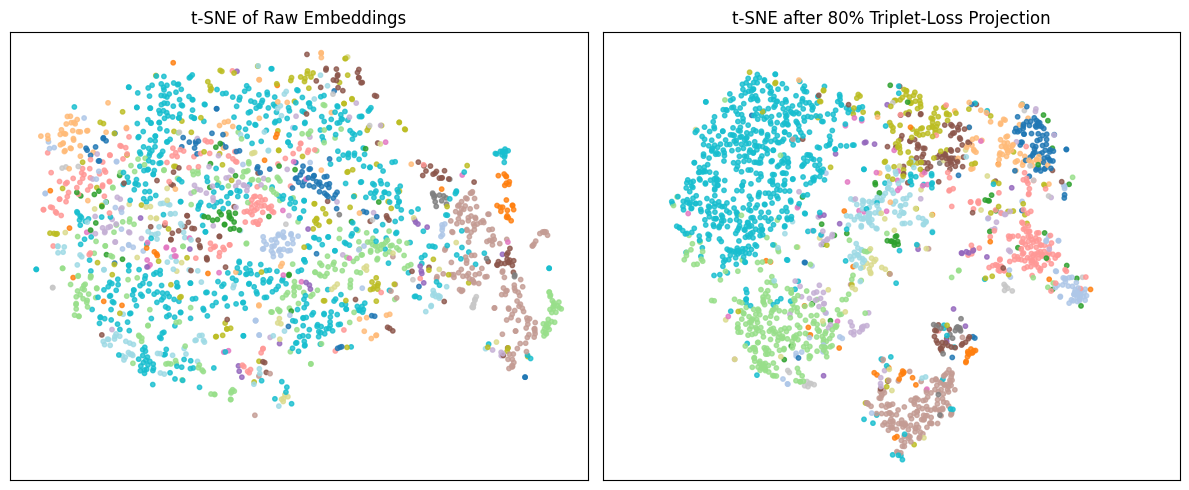

In [ ]:
import torch
import math

device = torch.device("cuda:0")

model.eval()
with torch.no_grad():
    Z = model(master_emb_t)
labels = master_labels_t

train_idxs_t = torch.tensor(train_idxs, dtype=torch.long, device=device)
test_idxs_t = torch.tensor(test_idxs, dtype=torch.long, device=device)

Z_train = Z[train_idxs_t]
y_train = labels[train_idxs_t]
Z_test = Z[test_idxs_t]
y_test = labels[test_idxs_t]

classes = torch.unique(y_train)
D = Z.size(1)
eps = 1e-6
const_term = D * math.log(2 * math.pi)

centroids = torch.stack([
    Z_train[y_train == c].mean(dim=0)
    for c in classes
], dim=0)

sims = Z_test @ centroids.t()
preds_cent = classes[torch.argmax(sims, dim=1)]
acc_centroid = (preds_cent == y_test).float().mean().item()
print(f"Centroid test accuracy: {acc_centroid * 100:.2f}%")

inv_covs = []
logdets = []

for c in classes:
    Xc = Z_train[y_train == c]
    mu = Xc.mean(dim=0, keepdim=True)
    Xc_centered = Xc - mu
    cov = (Xc_centered.t() @ Xc_centered) / Xc.size(0)
    cov += eps * torch.eye(D, device=device)
    inv_cov = torch.inverse(cov)
    sign, logdet = torch.slogdet(cov)
    inv_covs.append(inv_cov)
    logdets.append(logdet)

scores = []
for idx in range(len(classes)):
    mu = centroids[idx].unsqueeze(0)
    Xc_test = Z_test - mu
    tmp = Xc_test @ inv_covs[idx]
    qf = (tmp * Xc_test).sum(dim=1)
    log_prob = -0.5 * (qf + const_term + logdets[idx])
    scores.append(log_prob)

scores = torch.stack(scores, dim=1)
preds_gmm = classes[torch.argmax(scores, dim=1)]
acc_gmm = (preds_gmm == y_test).float().mean().item()
print(f"GMM test accuracy: {acc_gmm * 100:.2f}%")


C:\Users\sipay\miniconda3\envs\anime_rec_env\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


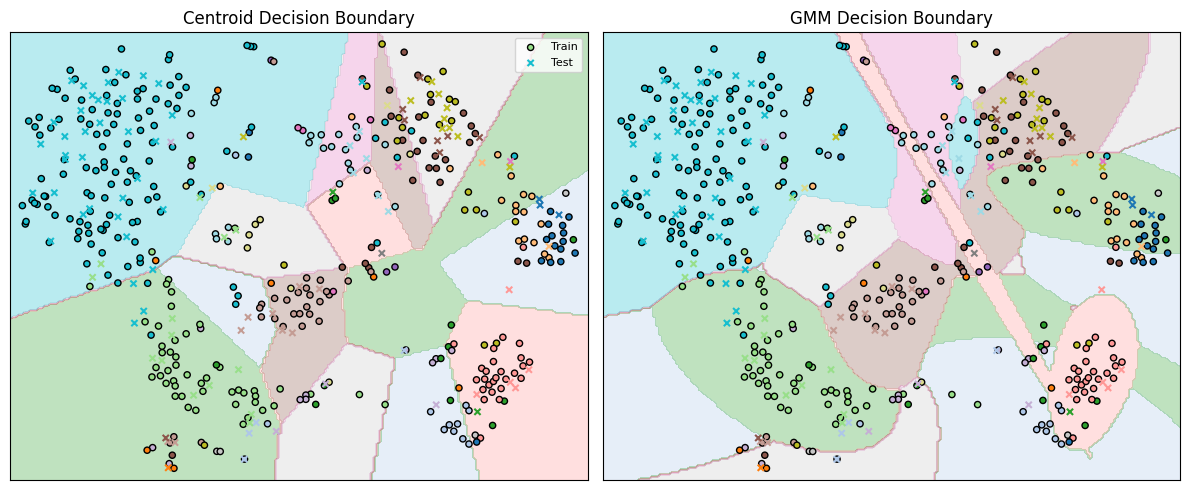

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0")
D = master_emb_t.size(1)

class StyleEncoder(nn.Module):
    def __init__(self, dim=D, dropout=0.3):
        super().__init__()
        self.fc = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        z = self.fc(self.drop(x))
        return F.normalize(z, p=2, dim=1)

model = StyleEncoder().to(device)
model.load_state_dict(torch.load("best_triplet_80pct.pt"))
model.eval()

with torch.no_grad():
    raw = master_emb_t
    proj = model(raw)

raw_np = raw.cpu().numpy()
proj_np = proj.cpu().numpy()
labels_np = master_labels_t.cpu().numpy()

max_pts = 2000
N = raw_np.shape[0]
idxs = np.random.RandomState(0).permutation(N)[:max_pts] if N > max_pts else np.arange(N)

raw_s = raw_np[idxs]
proj_s = proj_np[idxs]
labs_s = labels_np[idxs]

tsne_raw = TSNE(n_components=2, init="pca", perplexity=30, n_iter=1000, random_state=42)
raw_2d = tsne_raw.fit_transform(raw_s)

tsne_proj = TSNE(n_components=2, init="pca", perplexity=30, n_iter=1000, random_state=42)
proj_2d = tsne_proj.fit_transform(proj_s)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

ax1.scatter(raw_2d[:, 0], raw_2d[:, 1], c=labs_s, cmap="tab20", s=10, alpha=0.8)
ax1.set_title("t-SNE of Raw Embeddings")

ax2.scatter(proj_2d[:, 0], proj_2d[:, 1], c=labs_s, cmap="tab20", s=10, alpha=0.8)
ax2.set_title("t-SNE after 80% Triplet-Loss Projection")

for ax in (ax1, ax2):
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import torch
from transformers import LongformerTokenizer, LongformerModel

csv_path = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df = pd.read_csv(csv_path, encoding="latin-1")
print(f"Loaded {len(df)} rows")

model_name = "allenai/longformer-base-4096"
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Model loaded on:", next(model.parameters()).device)

sample = df['text'].iloc[0]
inputs = tokenizer(sample, return_tensors="pt", truncation=True, max_length=4096).to(device)

with torch.no_grad():
    output = model(**inputs)

print("Embedding shape:", output.last_hidden_state.shape)


Loaded 53678 rows


Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Model is on: cuda:0
Embedding shape: torch.Size([1, 1035, 768])


In [1]:
import torch

if torch.cuda.is_available():
    props = torch.cuda.get_device_properties(0)
    total = props.total_memory / 1024**3
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    free = total - reserved
    print(f"Total GPU memory:     {total:.2f} GB")
    print(f"Allocated memory:     {allocated:.2f} GB")
    print(f"Reserved memory:      {reserved:.2f} GB")
    print(f"Approximate free:     {free:.2f} GB")
else:
    print("CUDA is not available.")


Total GPU memory:     8.00 GB
Allocated memory:     0.00 GB
Reserved memory:      0.00 GB
Approximate free:     8.00 GB


In [ ]:
import pandas as pd
import torch
import time
from transformers import LongformerTokenizer, LongformerModel
from tqdm.auto import tqdm

csv_path = "../../Data/Gungor_2018_VictorianAuthorAttribution_data-train.csv"
df = pd.read_csv(csv_path, encoding="latin-1")

authors = sorted(df["author"].unique())
author_to_num = {name: i + 1 for i, name in enumerate(authors)}
num_to_author = {i + 1: name for i, name in enumerate(authors)}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
model = LongformerModel.from_pretrained("allenai/longformer-base-4096").to(device)
model.eval()

batch_size = 8
all_embeddings = []
metadata = []
timing = []

for num in tqdm(range(20, 51), desc="Authors"):
    author = num_to_author.get(num)
    if not author:
        continue

    texts = df[df["author"] == author]["text"].tolist()
    if not texts:
        continue

    to_embed = texts[:300]
    total_batches = (len(to_embed) + batch_size - 1) // batch_size

    start_time = time.time()

    for b_idx in tqdm(range(total_batches), desc=f"Author {num}", leave=False):
        i = b_idx * batch_size
        batch_texts = to_embed[i: i + batch_size]

        encoded = tokenizer(
            batch_texts,
            padding="longest",
            truncation=True,
            max_length=4096,
            return_tensors="pt"
        )

        input_ids = encoded.input_ids.to(device)
        attention_mask = encoded.attention_mask.to(device)

        with torch.no_grad():
            output = model(input_ids, attention_mask=attention_mask)

        last_hidden = output.last_hidden_state
        mask = attention_mask.unsqueeze(-1)
        summed = (last_hidden * mask).sum(dim=1)
        counts = mask.sum(dim=1)
        avg_embeddings = (summed / counts).cpu()

        for j, emb in enumerate(avg_embeddings):
            all_embeddings.append(emb)
            metadata.append({
                "author_num": num,
                "author_name": author,
                "local_index": i + j
            })

    elapsed = time.time() - start_time
    timing.append({
        "author_num": num,
        "author_name": author,
        "count": len(to_embed),
        "time_s": round(elapsed, 2)
    })

emb_tensor = torch.stack(all_embeddings)
save_dict = {"embeddings": emb_tensor, "metadata": metadata}
torch.save(save_dict, "victorian_20_50_embs.pt")

summary = pd.DataFrame(timing)
print("\nEmbedding speed summary:")
print(summary)


Authors:   0%|          | 0/31 [00:00<?, ?it/s]

Author 20:   0%|          | 0/38 [00:00<?, ?it/s]

Author 21:   0%|          | 0/38 [00:00<?, ?it/s]

Author 22:   0%|          | 0/38 [00:00<?, ?it/s]

Author 23:   0%|          | 0/38 [00:00<?, ?it/s]

Author 24:   0%|          | 0/38 [00:00<?, ?it/s]

Author 25:   0%|          | 0/38 [00:00<?, ?it/s]

Author 26:   0%|          | 0/38 [00:00<?, ?it/s]

Author 27:   0%|          | 0/38 [00:00<?, ?it/s]

Author 28:   0%|          | 0/38 [00:00<?, ?it/s]

Author 29:   0%|          | 0/38 [00:00<?, ?it/s]

Author 30:   0%|          | 0/38 [00:00<?, ?it/s]

Author 31:   0%|          | 0/38 [00:00<?, ?it/s]

Author 32:   0%|          | 0/38 [00:00<?, ?it/s]

Author 33:   0%|          | 0/38 [00:00<?, ?it/s]

Author 34:   0%|          | 0/38 [00:00<?, ?it/s]

Author 35:   0%|          | 0/38 [00:00<?, ?it/s]

Author 36:   0%|          | 0/38 [00:00<?, ?it/s]

Author 37:   0%|          | 0/38 [00:00<?, ?it/s]

Author 38:   0%|          | 0/38 [00:00<?, ?it/s]

Author 39:   0%|          | 0/38 [00:00<?, ?it/s]

Author 40:   0%|          | 0/38 [00:00<?, ?it/s]

Author 41:   0%|          | 0/38 [00:00<?, ?it/s]

Author 42:   0%|          | 0/38 [00:00<?, ?it/s]

Author 43:   0%|          | 0/38 [00:00<?, ?it/s]

Author 44:   0%|          | 0/38 [00:00<?, ?it/s]

Author 45:   0%|          | 0/38 [00:00<?, ?it/s]


Embedding speed summary:
    author_num  author_name  count  time_s
0           20           22    300   21.30
1           21           23    300   20.79
2           22           24    300   21.12
3           23           25    300   21.09
4           24           26    300   21.07
5           25           27    300   21.07
6           26           28    300   21.11
7           27           29    300   21.14
8           28           30    300   21.10
9           29           32    300   21.12
10          30           33    300   21.11
11          31           34    300   21.10
12          32           35    300   21.15
13          33           36    300   21.09
14          34           37    300   21.16
15          35           38    300   21.11
16          36           39    300   21.13
17          37           40    300   21.11
18          38           41    300   21.16
19          39           42    300   21.11
20          40           43    300   21.11
21          41           44 

In [4]:
import torch

save_path = "victorian_20_50_embs.pt"
torch.save({
    "embeddings": emb_tensor,
    "metadata": metadata
}, save_path)

print(f"✅ Saved {emb_tensor.size(0)} embeddings and metadata to '{save_path}'")


✅ Saved 7800 embeddings and metadata to 'victorian_20_50_embs.pt'


In [ ]:
import torch
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture

data = torch.load("victorian_20_50_embs.pt", weights_only=False)
embs = data["embeddings"].numpy()
metadata = data["metadata"]
labels = np.array([m["author_num"] for m in metadata])

unique_labels = np.unique(labels)

def evaluate_shot(K):
    support_idx, query_idx = [], []
    rng = np.random.RandomState(0)

    for lbl in unique_labels:
        idxs = np.where(labels == lbl)[0]
        if len(idxs) == 0:
            continue
        if len(idxs) < K:
            sup = idxs.tolist()
            qry = []
        else:
            perm = rng.permutation(idxs)
            sup = perm[:K].tolist()
            qry = perm[K:].tolist()
        support_idx.extend(sup)
        query_idx.extend(qry)

    sup_emb = embs[support_idx]
    sup_lbl = labels[support_idx]

    centers = {lbl: sup_emb[sup_lbl == lbl].mean(axis=0) for lbl in unique_labels}

    cent_preds = [
        min(unique_labels, key=lambda l: np.linalg.norm(x - centers[l]))
        for x in embs[query_idx]
    ]
    cent_acc = (np.array(cent_preds) == labels[query_idx]).mean() * 100

    if K >= 2:
        gmms = {}
        for lbl in unique_labels:
            pts = sup_emb[sup_lbl == lbl]
            gmms[lbl] = GaussianMixture(n_components=1, covariance_type='full', random_state=0).fit(pts)

        gmm_preds = [
            max(unique_labels, key=lambda l: gmms[l].score_samples(x.reshape(1, -1))[0])
            for x in embs[query_idx]
        ]
        gmm_acc = (np.array(gmm_preds) == labels[query_idx]).mean() * 100
    else:
        gmm_acc = np.nan

    return cent_acc, gmm_acc

results = []
for K in [1, 10, 250]:
    cent_acc, gmm_acc = evaluate_shot(K)
    results.append({
        "shots": K,
        "centroid_acc": round(cent_acc, 2),
        "gmm_acc": round(gmm_acc, 2)
    })
    print(f"Finished evaluation for {K}-shot.")

df_results = pd.DataFrame(results)
print(df_results)


Finished for K= 1
Finished for K= 10
Finished for K= 250


,shots,centroid_acc,gmm_acc
0,1,29.28,NaN
1,10,53.46,72.49
2,250,60.23,95.08


In [ ]:
import pandas as pd

df = pd.read_csv("AI_Human.csv", encoding="latin-1")
print("Columns:", df.columns.tolist())
df.columns = df.columns.str.strip()
print("Stripped columns:", df.columns.tolist())
label_col = [c for c in df.columns if "generated" in c.lower()]
if not label_col:
    raise ValueError("Couldn't find a ‘generated’ column!")
label_col = label_col[0]
print("Using label column:", label_col)

Columns: ['text', 'generated']
Stripped columns: ['text', 'generated']
Using label column: generated


In [ ]:
import torch
import torch.nn as nn

class StyleEncoder(nn.Module):
    def __init__(self, dim=768, dropout=0.3):
        super().__init__()
        self.fc   = nn.Linear(dim, dim)
        self.drop = nn.Dropout(dropout)
    def forward(self, x):
        return F.normalize(self.fc(self.drop(x)), p=2, dim=1)

se = StyleEncoder(dim=768, dropout=0.3).to(device)
se.load_state_dict(torch.load("best_triplet_80pct.pt", map_location=device))
se.eval()


StyleEncoder(
  (fc): Linear(in_features=768, out_features=768, bias=True)
  (drop): Dropout(p=0.3, inplace=False)
)

In [ ]:
import torch
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from transformers import LongformerTokenizer, LongformerModel
import torch.nn.functional as F
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

df = pd.read_csv("AI_Human.csv", encoding="latin-1")
ai_texts = df[df["generated"] == 1]["text"].tolist()[:10000]
human_texts = df[df["generated"] == 0]["text"].tolist()[:10000]

texts = ai_texts + human_texts
labels = np.array([1] * len(ai_texts) + [0] * len(human_texts))
N = len(texts)

print(f"Embedding {len(ai_texts)} AI + {len(human_texts)} Human → {N} texts")

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")
lfmodel = LongformerModel.from_pretrained("allenai/longformer-base-4096").to(device)
lfmodel.eval()

class StyleEncoder(torch.nn.Module):
    def __init__(self, dim=768, dropout=0.3):
        super().__init__()
        self.fc = torch.nn.Linear(dim, dim)
        self.drop = torch.nn.Dropout(dropout)
    def forward(self, x):
        return F.normalize(self.fc(self.drop(x)), p=2, dim=1)

style_encoder = StyleEncoder().to(device)
style_encoder.load_state_dict(torch.load("best_triplet_80pct.pt", map_location=device))
style_encoder.eval()

batch_size = 8
embeddings = []

for i in tqdm(range(0, N, batch_size), desc="Embedding batches"):
    batch = texts[i: i + batch_size]
    encoded = tokenizer(
        batch,
        padding="longest",
        truncation=True,
        max_length=4096,
        return_tensors="pt"
    )
    input_ids = encoded.input_ids.to(device)
    attention_mask = encoded.attention_mask.to(device)

    with torch.no_grad():
        output = lfmodel(input_ids, attention_mask=attention_mask).last_hidden_state
        pooled = (output * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.sum(1, keepdim=True)

    with torch.no_grad():
        style_vec = style_encoder(pooled)

    embeddings.append(style_vec.cpu().numpy())

embeddings = np.vstack(embeddings)
print("✅ Done embedding.")

classes = [0, 1]

def evaluate_few_shot(K):
    rng = np.random.RandomState(0)
    support_idx, query_idx = [], []

    for c in classes:
        idxs = np.where(labels == c)[0]
        perm = rng.permutation(idxs)
        sup = perm[:K] if len(idxs) >= K else idxs
        qry = perm[K:] if len(idxs) >= K else []
        support_idx.extend(sup.tolist())
        query_idx.extend(qry.tolist())

    Xsup, ysup = embeddings[support_idx], labels[support_idx]
    Xqry, yqry = embeddings[query_idx], labels[query_idx]

    centers = {c: Xsup[ysup == c].mean(0) for c in classes}
    cent_preds = [1 if np.linalg.norm(x - centers[1]) < np.linalg.norm(x - centers[0]) else 0 for x in Xqry]
    cent_acc = accuracy_score(yqry, cent_preds) * 100

    if K >= 2 and len(query_idx) > 0:
        gmms = {c: GaussianMixture(n_components=1, covariance_type="full", random_state=0).fit(Xsup[ysup == c]) for c in classes}
        gmm_preds = [max(classes, key=lambda c: gmms[c].score_samples(x.reshape(1, -1))[0]) for x in Xqry]
        gmm_acc = accuracy_score(yqry, gmm_preds) * 100
    else:
        gmm_acc = None

    return cent_acc, gmm_acc

results = []
for K in [1, 10, 250]:
    cent_acc, gmm_acc = evaluate_few_shot(K)
    print(f"{K}-shot → Centroid: {cent_acc:.2f}%", end="")
    if gmm_acc is not None:
        print(f" | GMM: {gmm_acc:.2f}%")
    else:
        print(" | GMM: N/A (K<2)")
    results.append({
        "shots": K,
        "centroid_acc (%)": round(cent_acc, 2),
        "gmm_acc (%)": round(gmm_acc, 2) if gmm_acc is not None else "N/A"
    })

df_results = pd.DataFrame(results)
print("\nFew-Shot Accuracy Summary:")
print(df_results.to_string(index=False))


Embedding 10000 AI + 10000 Human → total 20000 texts


Embedding batches:   0%|          | 0/2500 [00:00<?, ?it/s]

✅ Done embedding.
1-shot → Centroid: 75.81% | GMM: N/A (K<2)
10-shot → Centroid: 75.50% | GMM: 92.83%
250-shot → Centroid: 87.15% | GMM: 99.11%

Few-Shot Accuracy Summary:
 shots  centroid_acc (%) gmm_acc (%)
     1             75.81         N/A
    10             75.50       92.83
   250             87.15       99.11
